Creating referencing HOS07 and https://www.kaggle.com/code/jeetkhamar/card-classification-with-vanilla-cnns-92/notebook

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import pandas as pd

# Importing Dataset

## Unzipping

In [6]:
import zipfile

file_path = 'kaggle-cards.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('kaggle')

In [7]:
train_dir = "kaggle/train"
train_dataset_dir = pathlib.Path(train_dir)

val_dir = "kaggle/valid"
val_dataset_dir = pathlib.Path(val_dir)

test_dir = "kaggle/test"
test_dataset_dir = pathlib.Path(test_dir)

## Parameters and Hyperparameters

In [8]:
IMG_SIZE = 112
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 500

## Retrieving Images

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

In [10]:
train_dataset = image_dataset_from_directory(train_dataset_dir,
                                             batch_size = BATCH_SIZE,
                                             image_size = (IMG_SIZE, IMG_SIZE),
                                             shuffle = True)

Found 7624 files belonging to 53 classes.


In [11]:
val_dataset = image_dataset_from_directory(val_dataset_dir,
                                           batch_size = BATCH_SIZE,
                                           image_size = (IMG_SIZE, IMG_SIZE),
                                           shuffle = True)

Found 265 files belonging to 53 classes.


In [12]:
test_dataset = image_dataset_from_directory(test_dataset_dir,
                                            batch_size = BATCH_SIZE,
                                            image_size = (IMG_SIZE, IMG_SIZE),
                                            shuffle = True)

Found 265 files belonging to 53 classes.


## Retreiving classnames

In [13]:
class_names = train_dataset.class_names

## Visualing a sample of the dataset

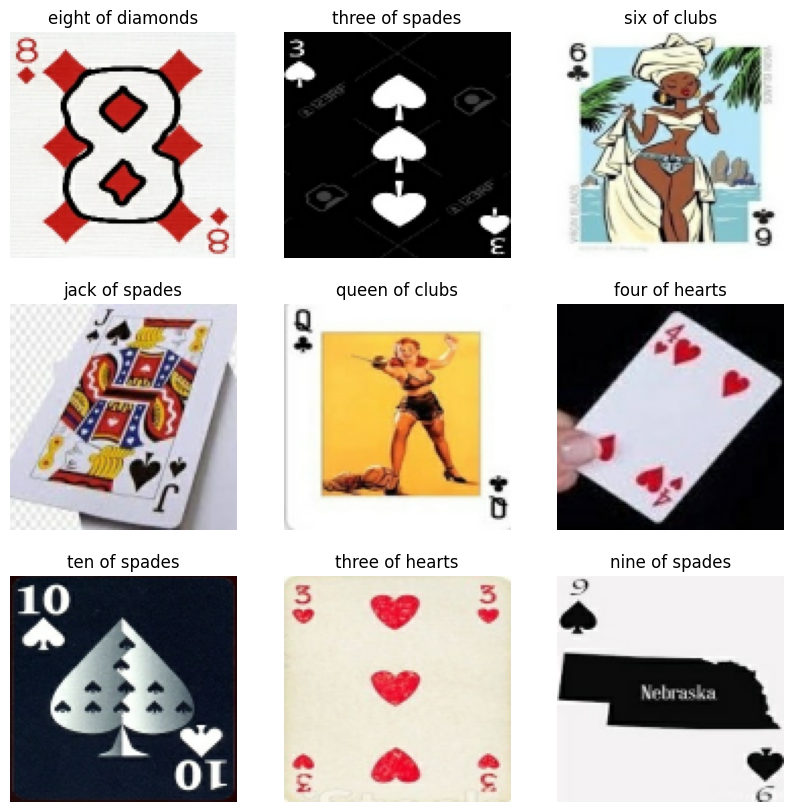

In [14]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data Augmentation

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# The Model

## Creation

In [16]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3,
                        padding="same",
                        activation="relu",
                        kernel_initializer="he_normal")

In [17]:
model = tf.keras.Sequential([
    resize_and_rescale,
    DefaultConv2D(filters=32, kernel_size=7, input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    DefaultConv2D(filters=32, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=64, kernel_size=5),
    DefaultConv2D(filters=64, kernel_size=5),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=53, activation="softmax")
])

In [18]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 112, 112, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 112, 112, 32)        4736      
                                                                 
 conv2d_1 (Conv2D)           (32, 112, 112, 32)        50208     
                                                                 
 max_pooling2d (MaxPooling2  (32, 56, 56, 32)          0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (32, 56, 56, 64)          51264     
                                                                 
 conv2d_3 (Conv2D)           (32, 56, 56, 64)          102464    
                                                      

## Compiling

In [19]:
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

## Training

In [20]:
from datetime import datetime
%load_ext tensorboard
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/500
 23/239 [=>............................] - ETA: 28:07 - loss: 4.1173 - accuracy: 0.0177

KeyboardInterrupt: 

## Evaluation

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy:', accuracy)

# Testing

In [ ]:
test_dataset

In [ ]:
predictions = model.predict(test_dataset)
predictions.shape

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'Predicted: {test_dataset.class_names[np.argmax(predictions[i])]}')
        plt.axis("off")
plt.show()